In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
csv_link = r"C:\Users\arnau\Documents\DSTI\ML_project\data\ibtracs.csv"

In [6]:
df_ibtracs = pd.read_csv(
    csv_link,
    skiprows=[1],
    header=0,
    low_memory=False
)

In [7]:
df_ibtracs.shape

(297098, 174)

In [8]:
df_ibtracs.describe()

,SEASON,NUMBER,LAT,LON,DIST2LAND,USA_SSHS
count,297098.000000,297098.000000,297098.000000,297098.000000,297098.000000,297098.000000
mean,2001.296677,53.524561,8.503028,54.066671,821.677689,-0.922537
std,12.787989,32.448238,19.973604,106.657605,714.864094,2.324156
min,1980.000000,1.000000,-68.500000,-179.800000,0.000000,-5.000000
25%,1990.000000,24.000000,-12.300000,-55.300000,226.000000,-2.000000
50%,2000.000000,53.000000,14.200000,96.800000,623.000000,-1.000000
75%,2013.000000,80.000000,21.300000,136.800000,1318.000000,0.000000
max,2025.000000,130.000000,70.700000,266.900000,4843.000000,5.000000


When we look at the CSV file, it seems there are a LOT of missing values.

In [9]:
df_ibtracs.isnull().sum().sum()

np.int64(73164)

73,164 missing values out of 51,695,052 cells is really small compared to how the CSV file looks. Let's take a column with a lot of missing values.

We will look at "WMO_WIND"; it's an arbitrary choice.

In [10]:
df_ibtracs.WMO_WIND.isnull().sum()

np.int64(0)

In [11]:
df_ibtracs.WMO_WIND

0          
1          
2          
3          
4          
         ..
297093     
297094     
297095     
297096     
297097     
Name: WMO_WIND, Length: 297098, dtype: object

In [12]:
df_ibtracs.WMO_WIND[0]

' '

So, there were no missing values. But when we look at the data, there are empty cells. Those cells are filled with a space character: " "

The next command will replace all the " " with null values and will also assign a numeric type to all columns with numerical values.

In [13]:
for col in df_ibtracs.columns:
    df_ibtracs[col] = df_ibtracs[col].replace(" ", np.nan)
    try:
        df_ibtracs[col] = pd.to_numeric(df_ibtracs[col])
    except ValueError:
        pass

C:\Users\arnau\AppData\Local\Temp\ipykernel_13172\8097902.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ibtracs[col] = df_ibtracs[col].replace(" ", np.nan)


In [14]:
df_ibtracs.isnull().sum().sum()

np.int64(41437829)

From 73,164 null values to 41,437,829, it represents 80% of null values.

We are looking at our target value to check the number of null values.

In [15]:
df_ibtracs.TD9636_STAGE.isnull().sum()

np.int64(248755)

Out of 297,098 rows, we have 248,755 null cells, leaving only 48,343 usable cells.

The goal of the next commands is to find an element that allows us to differentiate the cyclones.

In [16]:
df_ibtracs.SID.describe()

count            297098
unique             4767
top       1997013S08101
freq                352
Name: SID, dtype: object

In [17]:
df_ibtracs.NAME.describe()

count      297098
unique       1535
top       UNNAMED
freq        36655
Name: NAME, dtype: object

Unique values in SID = 4767 — Unique values in NAME = 1535.

So, there is probably a reuse of the same name for different SID

In [18]:
df_ibtracs[df_ibtracs['NAME'] == "PENI"]["SID"].unique()

array(['1980001S13173', '1990043S09206'], dtype=object)

For the name "PENI", we can see 2 different SID. So, we will only use the SID column to look at the precise storm.

We want to see if for the same SID, the agency TD9636 has not provided any STAGE, has partially provided a STAGE, or if the agency is present for the entire SID.

In [19]:
df_ibtracs["SID"].unique()

array(['1980001S13173', '1980002S15081', '1980003S15137', ...,
       '2024276S10076', '2024278N21265', '2024280N18146'], dtype=object)

So we delete the 'NAME' column, which has no value

In [20]:
df_tranform = df_ibtracs.drop(columns=["NAME"])

So a row will be defined by the SID, the storm, and ISO_TIME.

We will now focus on our target value: TD9636_STAGE

In [21]:
df_ibtracs.TD9636_STAGE.describe()

count    48343.000000
mean         2.034690
std          1.277956
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: TD9636_STAGE, dtype: float64

We will remove all null values from our column TD9636_STAGE for the sake of accuracy, as we do not wish to assign values through correlation

In [22]:
df_tranform = df_tranform.dropna(subset=["TD9636_STAGE"])

We now check if there are any columns that contain only null values in order to remove them

In [23]:
df_tranform.columns[df_tranform.isnull().all()]

Index(['USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE',
       'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE',
       'USA_R64_SW', 'USA_R64_NW', 'USA_POCI', 'USA_ROCI', 'USA_RMW',
       'USA_EYE', 'KMA_LAT', 'KMA_LON', 'KMA_CAT', 'KMA_WIND', 'KMA_PRES',
       'KMA_R50_DIR', 'KMA_R50_LONG', 'KMA_R50_SHORT', 'KMA_R30_DIR',
       'KMA_R30_LONG', 'KMA_R30_SHORT', 'NEWDELHI_POCI', 'REUNION_RMW',
       'REUNION_R34_NE', 'REUNION_R34_SE', 'REUNION_R34_SW', 'REUNION_R34_NW',
       'REUNION_R50_NE', 'REUNION_R50_SE', 'REUNION_R50_SW', 'REUNION_R50_NW',
       'REUNION_R64_NE', 'REUNION_R64_SE', 'REUNION_R64_SW', 'REUNION_R64_NW',
       'BOM_R34_NE', 'BOM_R34_NW', 'BOM_R50_NE', 'BOM_R50_SE', 'BOM_R50_SW',
       'BOM_R50_NW', 'BOM_R64_NE', 'BOM_R64_SE', 'BOM_R64_SW', 'BOM_R64_NW',
       'NADI_LAT', 'NADI_LON', 'NADI_CAT', 'NADI_WIND', 'NADI_PRES',
       'TD9636_PRES', 'TD9635_LAT', 'TD9635_LON', 'TD9635_WIND', 'TD9635_PRES',
       'TD9635_ROCI

In [24]:
df_tranform = df_tranform.drop(df_tranform.columns[df_tranform.isnull().all()], axis=1)

In [25]:
df_tranform

,SID,SEASON,NUMBER,BASIN,SUBBASIN,ISO_TIME,NATURE,LAT,LON,WMO_WIND,...,TD9636_WIND,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,BOM_GUST,BOM_GUST_PER,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,1980-01-01 00:00:00,TS,-12.5,172.5,NaN,...,25.0,-12.5,172.5,TC,25.0,NaN,NaN,NaN,6.0,350.0
1,1980001S13173,1980,1,SP,MM,1980-01-01 03:00:00,TS,-12.2,172.4,NaN,...,NaN,-12.2,172.4,TC,25.0,NaN,NaN,NaN,6.0,350.0
2,1980001S13173,1980,1,SP,MM,1980-01-01 06:00:00,TS,-11.9,172.4,NaN,...,NaN,-11.9,172.4,TC,25.0,NaN,NaN,NaN,5.0,360.0
3,1980001S13173,1980,1,SP,MM,1980-01-01 09:00:00,TS,-11.7,172.4,NaN,...,NaN,-11.7,172.4,TC,25.0,NaN,NaN,NaN,4.0,10.0
4,1980001S13173,1980,1,SP,MM,1980-01-01 12:00:00,TS,-11.5,172.5,NaN,...,NaN,-11.5,172.5,TC,25.0,NaN,NaN,NaN,4.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67405,1989354N05155,1989,129,WP,MM,1989-12-29 00:00:00,TS,14.6,141.6,NaN,...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67406,1989354N05155,1989,129,WP,MM,1989-12-29 03:00:00,TS,14.4,141.2,NaN,...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67407,1989354N05155,1989,129,WP,MM,1989-12-29 06:00:00,TS,14.3,140.8,NaN,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0
67408,1989354N05155,1989,129,WP,MM,1989-12-29 09:00:00,TS,14.1,140.4,NaN,...,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0


We can delete the columns ["SEASON", "NUMBER"] as they are no longer useful to us

In [26]:
df_tranform = df_tranform.drop(columns=["SEASON", "NUMBER"])

---

We also notice that there are several columns referring to LAT and LON. We will keep only the global LAT and LON, not the ones attached to the agencies

In [27]:
df_tranform.filter(like='LAT')

,LAT,USA_LAT,TOKYO_LAT,CMA_LAT,HKO_LAT,NEWDELHI_LAT,REUNION_LAT,BOM_LAT,WELLINGTON_LAT,DS824_LAT,TD9636_LAT,NEUMANN_LAT
0,-12.5,-12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.5,-12.5,-12.5
1,-12.2,-12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.2,-12.2,-12.2
2,-11.9,-11.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.9,-12.0,-11.9
3,-11.7,-11.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.7,-11.7,-11.7
4,-11.5,-11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.5,-11.5,-11.5
...,...,...,...,...,...,...,...,...,...,...,...,...
67405,14.6,14.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.6,NaN
67406,14.4,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.4,NaN
67407,14.3,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.3,NaN
67408,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.1,NaN


In [28]:
df_tranform = df_tranform.drop(columns = df_tranform.filter(like='_LAT'))

In [29]:
df_tranform.shape

(48343, 85)

In [30]:
df_tranform.filter(like='LON')

,LON,USA_LON,TOKYO_LON,TOKYO_R50_LONG,TOKYO_R30_LONG,CMA_LON,HKO_LON,NEWDELHI_LON,REUNION_LON,BOM_LON,WELLINGTON_LON,DS824_LON,TD9636_LON,NEUMANN_LON
0,172.5,172.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.5,172.5,172.5
1,172.4,172.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.4,172.5,172.4
2,172.4,172.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.4,172.4,172.4
3,172.4,172.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.4,172.5,172.4
4,172.5,172.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.5,172.5,172.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67405,141.6,141.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.6,NaN
67406,141.2,141.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.2,NaN
67407,140.8,140.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.8,NaN
67408,140.4,140.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.4,NaN


In [31]:
df_tranform = df_tranform.drop(columns = df_tranform.filter(like='_LON'))

In [32]:
df_tranform.shape

(48343, 72)

---

We will now focus on two metrics that seem important in the categorization of the cyclone: ["WIND", "PRES"]

--

WIND

In [33]:
df_w = df_tranform.filter(like='WIND')

In [34]:
df_w

,WMO_WIND,USA_WIND,TOKYO_WIND,CMA_WIND,HKO_WIND,NEWDELHI_WIND,REUNION_WIND,BOM_WIND,WELLINGTON_WIND,DS824_WIND,TD9636_WIND,NEUMANN_WIND
0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,25.0
1,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,25.0
2,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,25.0
3,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,25.0
4,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
67405,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN
67406,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN
67407,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
67408,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN


In [35]:
df_w.isnull().sum().sort_values()

USA_WIND            7876
TD9636_WIND         8647
WMO_WIND           31086
CMA_WIND           33190
NEUMANN_WIND       33666
HKO_WIND           35341
TOKYO_WIND         37501
BOM_WIND           42057
WELLINGTON_WIND    43960
REUNION_WIND       44463
DS824_WIND         44691
NEWDELHI_WIND      47777
dtype: int64

The goal here will be to try to gather as much data as possible to create a 'WIND' column that will collect data from all agencies. For optimization purposes, we will take the 'USA_WIND' column as a reference and then add the data from the other agencies

The unit of measurement used for WIND is knots, with measurements taken at different times depending on the agency: 
- WMO_WIND :           ?
- USA_WIND :        1-min.mean
- TOKYO_WIND :      10-min.mean
- CMA_WIND :        2-min.mean
- HKO_WIND :        10-min.mean
- NEWDELHI_WIND :   3-min.mean
- REUNION_WIND :    10-min.mean
- BOM_WIND :        10-min.mean
- WELLINGTON_WIND : 10-min.mean
- DS824_WIND :      1-min.mean
- TD9636_WIND :     1-min.mean
- NEUMANN_WIND :    1-min.mean

- We need to ensure proper conversion to the correct unit of measurement. The documentation provides the values to apply for the conversion.
- We will work with the 1-minute mean. To convert from max speed 10-minute mean to 1-minute mean: *1.12 (IBTrACS technical details p5).
- Therefore, we will not be able to work with columns that do not respect both units.

In [36]:
df_w = df_w.drop(columns = ["WMO_WIND", "CMA_WIND", "NEWDELHI_WIND"])

In [37]:
df_w[["BOM_WIND", "WELLINGTON_WIND", "REUNION_WIND", "HKO_WIND", "TOKYO_WIND"]] = df_w[["BOM_WIND", "WELLINGTON_WIND", "REUNION_WIND", "HKO_WIND", "TOKYO_WIND"]] * 1.12

In [38]:
df_w["WIND"] = df_w["USA_WIND"]

In [39]:
for column in df_w.columns:
    df_w["WIND"] = df_w["WIND"].fillna(df_w[column])

In [40]:
df_w.isnull().sum().sort_values()

WIND                3318
USA_WIND            7876
TD9636_WIND         8647
NEUMANN_WIND       33666
HKO_WIND           35341
TOKYO_WIND         37501
BOM_WIND           42057
WELLINGTON_WIND    43960
REUNION_WIND       44463
DS824_WIND         44691
dtype: int64

"WIND" seems to be a critical data point in the categorization of the cyclone

In [41]:
df_tranform["WIND"] = df_w["WIND"]

We can now delete the "WIND" columns belonging to the agencies

In [42]:
df_tranform = df_tranform.drop(columns = df_tranform.filter(like ='_WIND'))

--

PRES

In [43]:
df_p = df_tranform.filter(like='PRES')

In [44]:
df_p

,WMO_PRES,USA_PRES,TOKYO_PRES,CMA_PRES,HKO_PRES,NEWDELHI_PRES,REUNION_PRES,BOM_PRES,BOM_PRES_METHOD,WELLINGTON_PRES,DS824_PRES,NEUMANN_PRES
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
67405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_p.isnull().sum().sort_values()

TOKYO_PRES         32937
CMA_PRES           33176
WMO_PRES           33584
HKO_PRES           35341
BOM_PRES           42193
WELLINGTON_PRES    43960
REUNION_PRES       45186
NEUMANN_PRES       45442
USA_PRES           46775
BOM_PRES_METHOD    47850
DS824_PRES         47998
NEWDELHI_PRES      48118
dtype: int64

There is no conversion issue for this metric, as all the columns are in the same unit of measurement. We will proceed as we did for "WIND"

In [46]:
df_p["PRES"] = df_p["TOKYO_PRES"]

C:\Users\arnau\AppData\Local\Temp\ipykernel_13172\950906820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p["PRES"] = df_p["TOKYO_PRES"]


In [47]:
for column in df_p.columns:
    df_p["PRES"] = df_p["PRES"].fillna(df_p[column])

C:\Users\arnau\AppData\Local\Temp\ipykernel_13172\3986284150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p["PRES"] = df_p["PRES"].fillna(df_p[column])


In [48]:
df_p.isnull().sum().sort_values()

PRES               17595
TOKYO_PRES         32937
CMA_PRES           33176
WMO_PRES           33584
HKO_PRES           35341
BOM_PRES           42193
WELLINGTON_PRES    43960
REUNION_PRES       45186
NEUMANN_PRES       45442
USA_PRES           46775
BOM_PRES_METHOD    47850
DS824_PRES         47998
NEWDELHI_PRES      48118
dtype: int64

In [49]:
df_tranform["PRES"] = df_p["PRES"]

In [50]:
df_tranform = df_tranform.drop(columns = df_tranform.filter(like ='_PRES'))

In [51]:
del df_p, df_w

In [52]:
df_tranform.PRES.isnull().sum()

np.int64(17595)

In [53]:
df_tranform.PRES.describe()

count    30748.000000
mean       984.249610
std         20.327869
min        880.000000
25%        975.000000
50%        990.000000
75%        999.000000
max       1015.000000
Name: PRES, dtype: float64

---

In [59]:
df_tranform.shape

(48343, 50)

Sum of null values for each column

In [58]:
df_tranform.isnull().sum().sort_values(ascending=False)

BOM_RMW            48341
USA_RECORD         48339
BOM_R34_SE         48336
BOM_R34_SW         48336
BOM_TNUM           48274
BOM_POCI           48257
BOM_EYE            48225
NEWDELHI_CI        48052
NEWDELHI_DP        47804
NEWDELHI_GRADE     47463
BOM_POS_METHOD     47147
BOM_GUST_PER       46920
BOM_GUST           46920
REUNION_CI         46693
BOM_ROCI           46670
REUNION_TNUM       45691
BOM_CI             45269
DS824_STAGE        44586
REUNION_TYPE       43052
TOKYO_R50_SHORT    42337
BOM_TYPE           42048
TOKYO_LAND         40599
TOKYO_R30_SHORT    37503
USA_STATUS         36511
HKO_CAT            35133
NEUMANN_CLASS      33535
CMA_CAT            33049
TOKYO_R50_DIR      32904
TOKYO_R30_DIR      32904
TOKYO_GRADE        32904
WMO_AGENCY         28241
USA_AGENCY         27508
PRES               17595
USA_ATCF_ID         6652
WIND                3318
LANDFALL             450
STORM_SPEED            1
STORM_DIR              1
USA_SSHS               0
IFLAG                  0


We will delete columns for the following reasons:
- More than 90% missing values
- The "stage" from another agency (this could be considered "cheating" ?)
- The documentation shows that the column is not important (agency ID, name, etc)

List of stage ratings by agency : 

[TOKYO_GRADE, CMA_CAT, NEUMANN_CLASS, NEWDELHI_GRADE,
HKO_CAT, USA_STATUS, BOM_TYPE, REUNION_TYPE, DS824_STAGE, ]

In [ ]:
df_tranform = df_tranform.drop(columns= ["TOKYO_GRADE", "CMA_CAT", 
                                         "NEUMANN_CLASS", "NEWDELHI_GRADE",
                                         "HKO_CAT", "USA_STATUS", "BOM_TYPE", 
                                         "REUNION_TYPE", "DS824_STAGE"])

List of columns that are unimportant or unusable (documentation):

[USA_AGENCY, WMO_AGENCY, TRACK_TYPE, USA_ATCF_ID,]

In [64]:
df_tranform = df_tranform.drop(columns= ["USA_AGENCY", "WMO_AGENCY", 
                                         "TRACK_TYPE", "USA_ATCF_ID"])

In [65]:
df_tranform.shape

(48343, 37)

More than 90% missing values

In [67]:
df_tranform.columns[df_tranform.isnull().sum() > 43500]

Index(['USA_RECORD', 'NEWDELHI_CI', 'NEWDELHI_DP', 'REUNION_TNUM',
       'REUNION_CI', 'BOM_TNUM', 'BOM_CI', 'BOM_RMW', 'BOM_R34_SE',
       'BOM_R34_SW', 'BOM_ROCI', 'BOM_POCI', 'BOM_EYE', 'BOM_POS_METHOD',
       'BOM_GUST', 'BOM_GUST_PER'],
      dtype='object')

In [68]:
df_tranform = df_tranform.drop(columns= df_tranform.columns[df_tranform.isnull().sum() > 43500])

In [70]:
df_tranform.isnull().sum().sort_values(ascending=False)

TOKYO_R50_SHORT    42337
TOKYO_LAND         40599
TOKYO_R30_SHORT    37503
TOKYO_R50_DIR      32904
TOKYO_R30_DIR      32904
PRES               17595
WIND                3318
LANDFALL             450
STORM_SPEED            1
STORM_DIR              1
SID                    0
SUBBASIN               0
BASIN                  0
NATURE                 0
ISO_TIME               0
IFLAG                  0
DIST2LAND              0
LAT                    0
USA_SSHS               0
LON                    0
TD9636_STAGE           0
dtype: int64

??????  There might be work to group all the data from r50/r30/r34 of all the agencies. For now, I will delete them.    ??????

In [71]:
df_tranform = df_tranform.drop(columns= ["TOKYO_R50_SHORT", 
                                         "TOKYO_LAND", 
                                         "TOKYO_R30_SHORT",
                                         "TOKYO_R50_DIR",
                                         "TOKYO_R30_DIR"])


In [72]:
df_tranform.shape

(48343, 16)

In [73]:
df_tranform

,SID,BASIN,SUBBASIN,ISO_TIME,NATURE,LAT,LON,DIST2LAND,LANDFALL,IFLAG,USA_SSHS,TD9636_STAGE,STORM_SPEED,STORM_DIR,WIND,PRES
0,1980001S13173,SP,MM,1980-01-01 00:00:00,TS,-12.5,172.5,647,647.0,O_________OO_O_,-1,1.0,6.0,350.0,25.0,NaN
1,1980001S13173,SP,MM,1980-01-01 03:00:00,TS,-12.2,172.4,653,653.0,P_________PP_P_,-1,1.0,6.0,350.0,25.0,NaN
2,1980001S13173,SP,MM,1980-01-01 06:00:00,TS,-11.9,172.4,670,670.0,O_________OP_O_,-1,1.0,5.0,360.0,25.0,NaN
3,1980001S13173,SP,MM,1980-01-01 09:00:00,TS,-11.7,172.4,682,682.0,P_________PP_P_,-1,1.0,4.0,10.0,25.0,NaN
4,1980001S13173,SP,MM,1980-01-01 12:00:00,TS,-11.5,172.5,703,703.0,O_________OO_O_,-1,1.0,4.0,20.0,25.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67405,1989354N05155,WP,MM,1989-12-29 00:00:00,TS,14.6,141.6,1760,1716.0,O__________O___,-1,1.0,9.0,250.0,25.0,NaN
67406,1989354N05155,WP,MM,1989-12-29 03:00:00,TS,14.4,141.2,1713,1669.0,P__________P___,-1,1.0,9.0,250.0,25.0,NaN
67407,1989354N05155,WP,MM,1989-12-29 06:00:00,TS,14.3,140.8,1669,1622.0,O__________P___,-1,1.0,8.0,250.0,25.0,NaN
67408,1989354N05155,WP,MM,1989-12-29 09:00:00,TS,14.1,140.4,1622,1578.0,P__________P___,-1,1.0,8.0,250.0,23.0,NaN


The SID column should be deleted before working on the model

---

Let's move on to the columns, review their usefulness, and possibly rework them

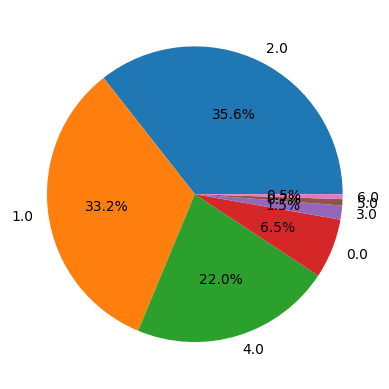

In [75]:
plt.pie(df_tranform.TD9636_STAGE.value_counts(), labels=df_tranform.TD9636_STAGE.value_counts().index, autopct='%1.1f%%')
plt.show()

Observations on the BASIN and SUBBASIN

In [76]:
df_tranform.BASIN.value_counts()

BASIN
WP    19796
SI    11008
EP     9831
SP     5752
NI     1956
Name: count, dtype: int64

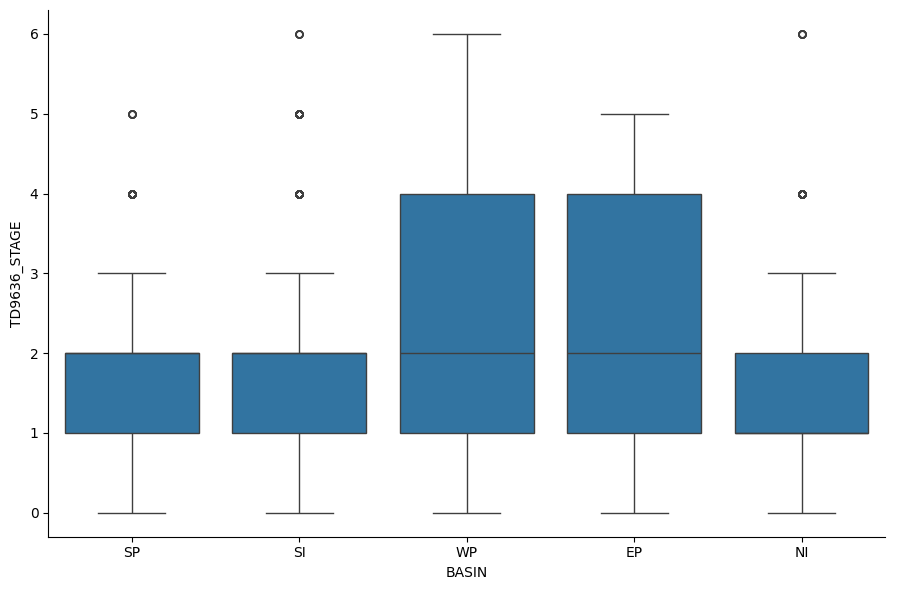

In [79]:
sns.catplot(data=df_tranform, x="BASIN", y="TD9636_STAGE", kind="box", height=6, aspect=1.5)
plt.show()


In [81]:
df_tranform.SUBBASIN.value_counts()

SUBBASIN
MM    38602
WA     4004
EA     2213
CP     1568
BB     1360
AS      596
Name: count, dtype: int64

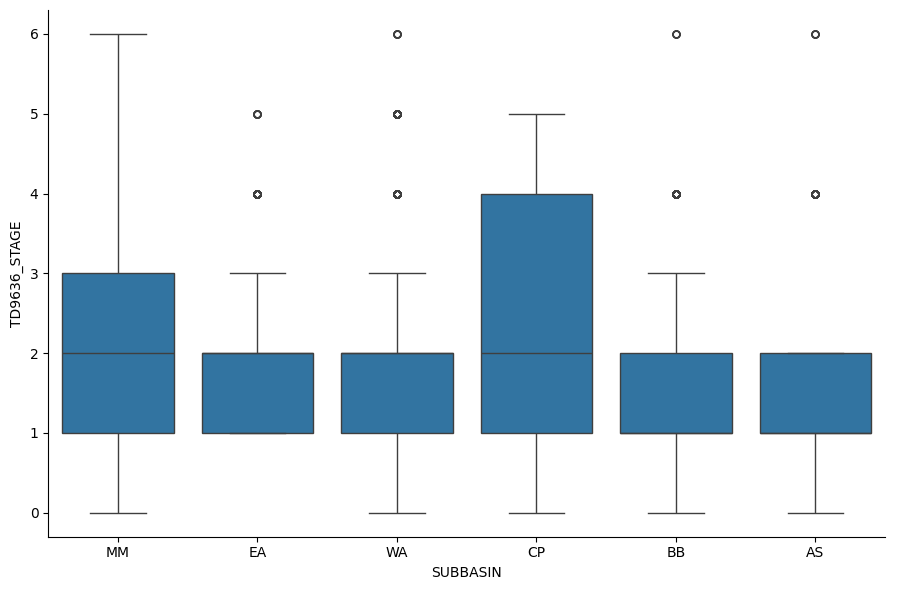

In [80]:
sns.catplot(data=df_tranform, x="SUBBASIN", y="TD9636_STAGE", kind="box", height=6, aspect=1.5)
plt.show()

Conclusion: As for the BASIN, the data seems to be usable. The use of SUBBASIN appears more complicated due to the lack of data diversity, with "MM" representing 80% of the values.

NATURE

In [82]:
df_tranform.NATURE.value_counts()

NATURE
TS    42660
MX     3077
DS     2305
ET      171
NR      130
Name: count, dtype: int64

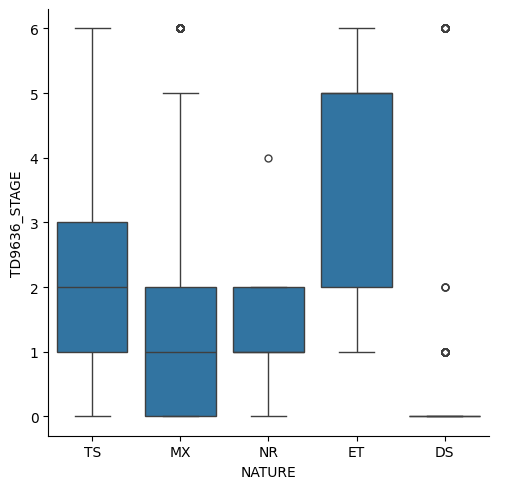

In [83]:
sns.catplot(data=df_tranform, x="NATURE", y="TD9636_STAGE", kind="box")
plt.show()

Conclusion : ???

TIME

In [88]:
df_tranform.ISO_TIME = pd.to_datetime(df_tranform.ISO_TIME)

In [89]:
df_tranform['year'] = df_tranform['ISO_TIME'].dt.year
df_tranform['month'] = df_tranform['ISO_TIME'].dt.month
df_tranform['day'] = df_tranform['ISO_TIME'].dt.day
df_tranform['hour'] = df_tranform['ISO_TIME'].dt.hour
df_tranform['minute'] = df_tranform['ISO_TIME'].dt.minute
df_tranform['second'] = df_tranform['ISO_TIME'].dt.second

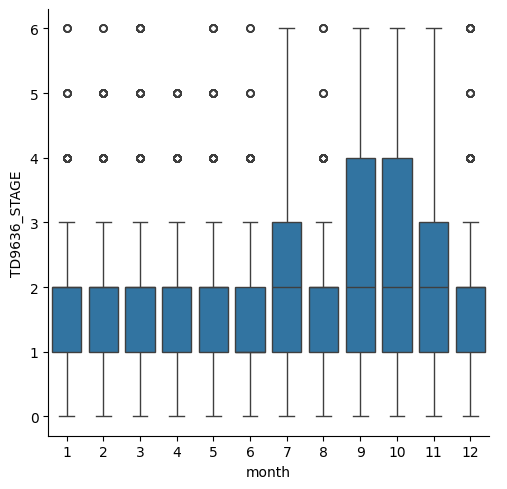

In [108]:
sns.catplot(data=df_tranform, x="month", y="TD9636_STAGE", kind="box")

<Axes: xlabel='month', ylabel='TD9636_STAGE'>

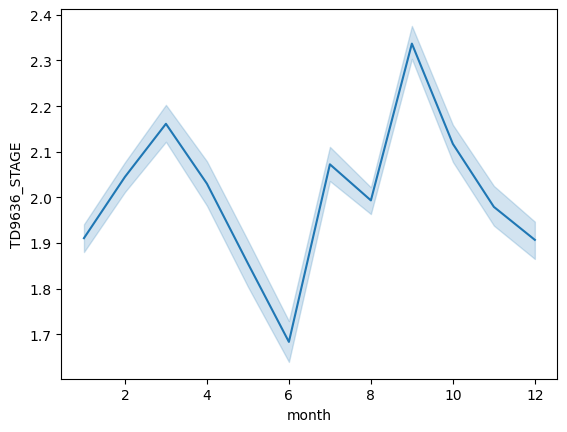

In [ ]:
sns.lineplot(x="month", y="TD9636_STAGE", data = df_tranform)

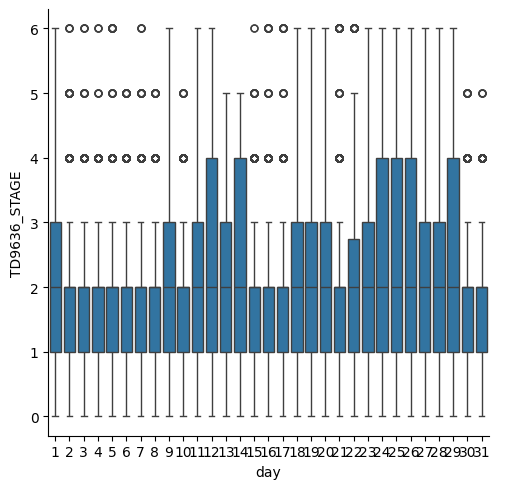

In [95]:
sns.catplot(data=df_tranform, x="day", y="TD9636_STAGE", kind="box")

<Axes: xlabel='day', ylabel='TD9636_STAGE'>

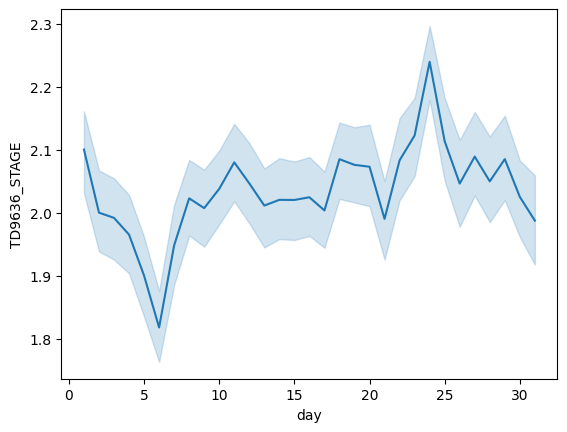

In [104]:
sns.lineplot(x="day", y="TD9636_STAGE", data = df_tranform)

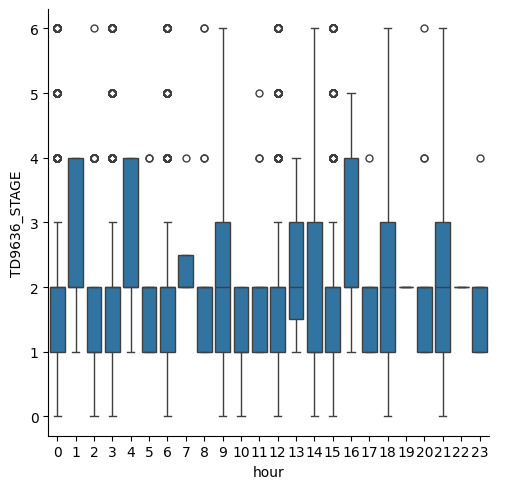

In [96]:
sns.catplot(data=df_tranform, x="hour", y="TD9636_STAGE", kind="box")

<Axes: xlabel='hour', ylabel='TD9636_STAGE'>

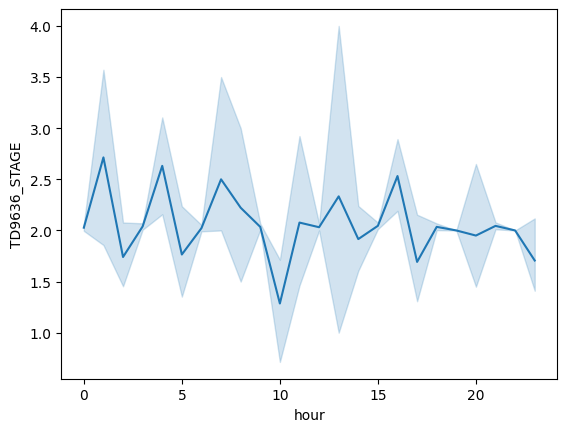

In [106]:
sns.lineplot(x="hour", y="TD9636_STAGE", data = df_tranform)

In [99]:
df_tranform.minute.value_counts()

minute
0     48339
30        3
40        1
Name: count, dtype: int64

In [100]:
df_tranform.second.value_counts()

second
0    48343
Name: count, dtype: int64

Conclusion: We delete the minutes and seconds, and since the year value is not cyclical, it likely doesn't have much importance. 

As for the rest?

WIND / PRES

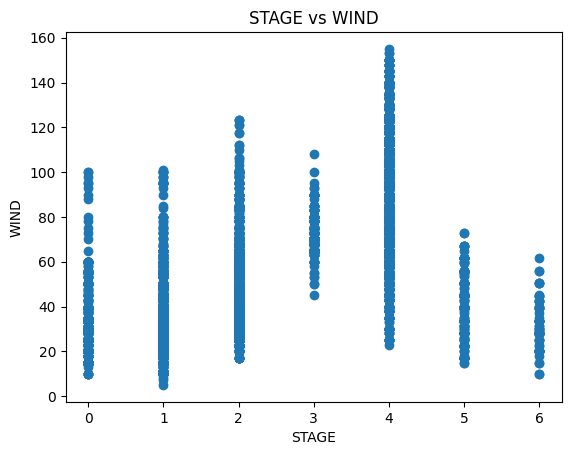

In [85]:
plt.scatter(df_tranform.TD9636_STAGE,df_tranform.WIND)
plt.title("STAGE vs WIND")
plt.xlabel("STAGE")
plt.ylabel("WIND")
plt.show()

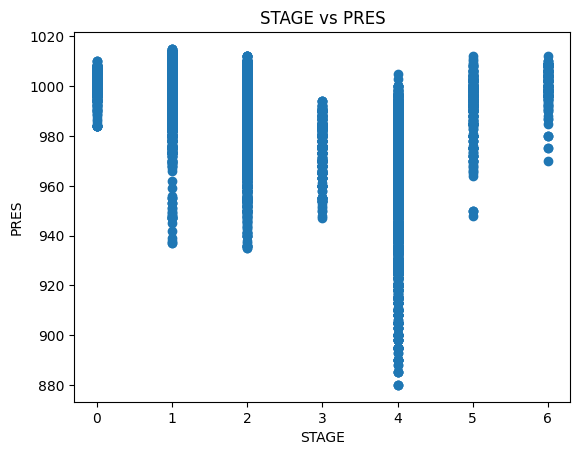

In [86]:
plt.scatter(df_tranform.TD9636_STAGE,df_tranform.PRES)
plt.title("STAGE vs PRES")
plt.xlabel("STAGE")
plt.ylabel("PRES")
plt.show()

Text(0.5, 1.0, 'WIND vs PRES')

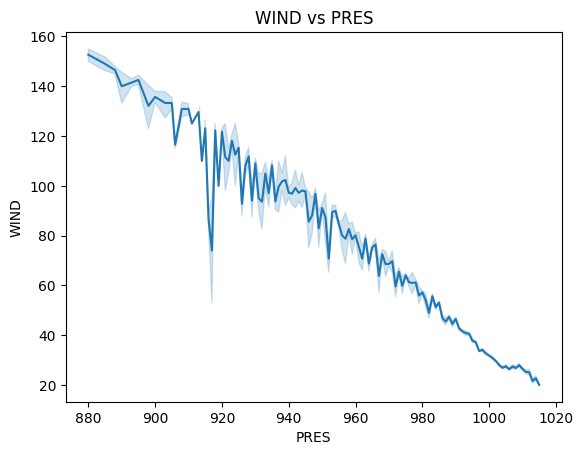

In [110]:
sns.lineplot(x="PRES", y="WIND", data = df_tranform)
plt.title("WIND vs PRES")


Conclusion : ??? 

In [114]:
import plotly.express as px
fig = px.scatter_map(df_tranform, lat="LAT", lon="LON", color="TD9636_STAGE",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=1, zoom=1,
                  map_style="basic")
fig.show()

For the moment, I just feel like everything is random, I don't understand.